In [1]:
import biosig
import json

In [2]:
HDR=json.loads(biosig.header('BCICIV_2b_gdf/B0101T.gdf'))

In [3]:
HDR.keys()

dict_keys(['TYPE', 'VERSION', 'Filename', 'NumberOfChannels', 'NumberOfRecords', 'SamplesPerRecords', 'NumberOfSamples', 'Samplingrate', 'StartOfRecording', 'TimezoneMinutesEastOfUTC', 'NumberOfSweeps', 'NumberOfGroupsOrUserSpecifiedEvents', 'Patient', 'CHANNEL', 'EVENT'])

In [4]:
sr  = HDR['Samplingrate']
sr

250.0

In [42]:
import pandas as pd
events = pd.json_normalize(HDR['EVENT'])
events[:20]

,TYP,POS,DUR,Description
0,0x7ffe,0.000,0.000,start of a new segment (after a break)
1,0x0114,1.996,60.000,eeg:Idling EEG - eyes open
2,0x0115,66.996,60.000,eeg:Idling EEG - eyes closed
3,0x0439,131.996,15.000,eye blinks
4,0x0437,151.996,15.000,eye rotation (clockwise)
5,0x0436,171.996,15.000,vertical eye movement
6,0x0435,191.996,15.000,horizontal eye movement
7,0x7ffe,209.004,0.000,start of a new segment (after a break)
8,0x0300,220.556,8.000,"Start of Trial, Trigger at t=0s"
9,0x0301,223.556,1.252,"class1, Left hand"


In [6]:
data=biosig.data('BCICIV_2b_gdf/B0101T.gdf').T
data.shape

(6, 604803)

In [7]:
import numpy as np
def time_ind_conversion(sr, t):
    return int(np.round(sr*t))

In [25]:
t_start = time_ind_conversion(sr, events.POS[9])
t_end = time_ind_conversion(sr, events.POS[9]+events.DUR[9])
left_test = data[:, t_start:t_end]
left_test.shape

(6, 313)

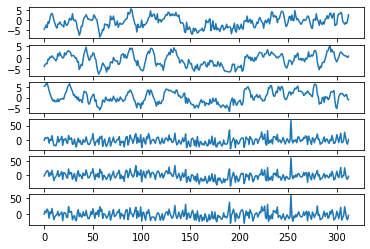

In [27]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_test[i, :])
    

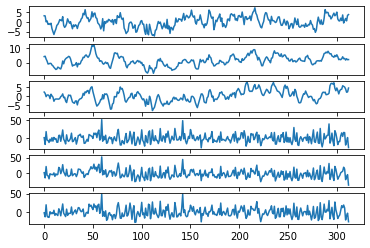

In [43]:
t_start = time_ind_conversion(sr, events.POS[11])
t_end = time_ind_conversion(sr, events.POS[11]+events.DUR[11])
right_test = data[:, t_start:t_end]
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_test[i, :])

## High pass approach

It is noted in the literature that while performing any motor imagery tasks, two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) bands are actively involved.

In [18]:
# from A1
from scipy.signal import butter, sosfiltfilt, sosfreqz 

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

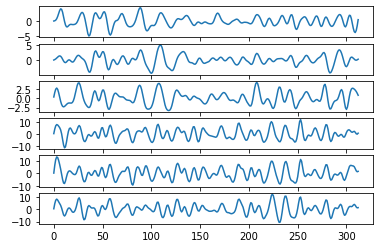

In [41]:
lowcut = 7
highcut= 30
left_filtered = butter_bandpass_filter(left_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(left_filtered[i,:])

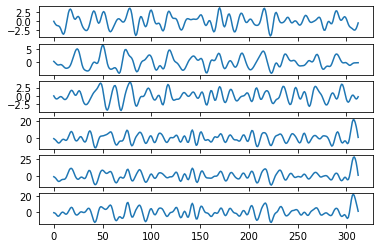

In [44]:
right_filtered = butter_bandpass_filter(right_test, lowcut, highcut, sr)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(right_filtered[i,:])

## FFT approach

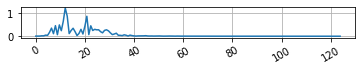

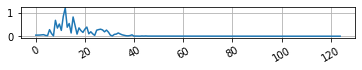

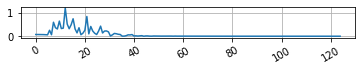

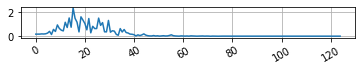

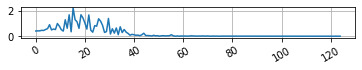

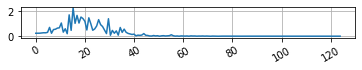

In [50]:
from scipy.fft import fft, fftfreq
N = left_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(left_filtered[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()


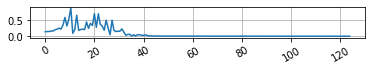

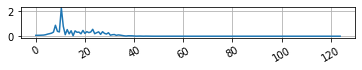

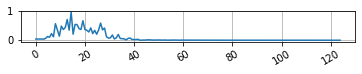

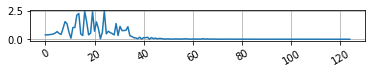

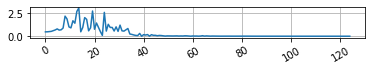

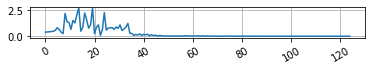

In [51]:
N = right_filtered.shape[1]
T = 1/sr
for i in range(6):
    yf = fft(right_filtered[i,:])
    xf = fftfreq(N, T)[:N//2]
    plt.subplot(6, 1, i+1)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.xticks(rotation=30)
    plt.show()


## Classification on raw data (just for fun...)

In [73]:
import os
data_path = './BCICIV_2b_gdf/'
files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
train_files = [f for f in files if f[-5]=='T']
test_files = [f for f in files if f[-5]=='E']
# for testing purposes only
train_files = train_files[:5]
test_files = test_files[:2]

In [102]:
def populate_data(files):
    labels = []
    data = []
    for i in train_files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)].reset_index(drop=True)
        all_data = biosig.data(i).T
        for j in range(len(mi_events)):
            t_start = time_ind_conversion(sr, mi_events.POS[j])
            t_end = time_ind_conversion(sr, mi_events.POS[j]+mi_events.DUR[j])
            event_data = all_data[:, t_start:t_end]
            data.append(event_data)
            labels.append(mi_events.Description[j])
    return data, labels
train_data, train_label = populate_data(train_files)
test_data, test_label = populate_data(test_files)

In [103]:
len(train_data)

720

In [63]:
import keras

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`